**непараметрическая регрессия**

_задача_: построить регрессию на данных климатических наблюдений

## качаем данные

In [1]:
# !wget -c https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip -d jena_climate jena_climate_2009_2016.csv.zip 

## конвертируем данные

In [2]:
import pandas as pd
df = pd.read_csv('jena_climate/jena_climate_2009_2016.csv')
print(len(df))

420451


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420451 non-null  object 
 1   p (mbar)         420451 non-null  float64
 2   T (degC)         420451 non-null  float64
 3   Tpot (K)         420451 non-null  float64
 4   Tdew (degC)      420451 non-null  float64
 5   rh (%)           420451 non-null  float64
 6   VPmax (mbar)     420451 non-null  float64
 7   VPact (mbar)     420451 non-null  float64
 8   VPdef (mbar)     420451 non-null  float64
 9   sh (g/kg)        420451 non-null  float64
 10  H2OC (mmol/mol)  420451 non-null  float64
 11  rho (g/m**3)     420451 non-null  float64
 12  wv (m/s)         420451 non-null  float64
 13  max. wv (m/s)    420451 non-null  float64
 14  wd (deg)         420451 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [4]:
# %%time

# df['Date Time'] = pd.to_datetime(df['Date Time']) # конвертируем дату и время

In [5]:
from tqdm.notebook import tqdm
tqdm.pandas()

df['Date Time'] = df['Date Time'].progress_apply(pd.to_datetime) # конвертируем дату и время

  0%|          | 0/420451 [00:00<?, ?it/s]

In [6]:
df.sample(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
213586,2013-01-22 06:10:00,977.86,-7.65,267.22,-9.15,88.9,3.43,3.05,0.38,1.94,3.12,1281.48,2.07,2.96,41.02
187203,2012-07-23 01:00:00,1003.13,10.06,282.97,7.54,84.3,12.34,10.41,1.94,6.48,10.37,1229.01,0.16,0.36,339.50


In [7]:
df.describe([.01,.1,.25,.5,.75,.95]).T.drop(columns=['count']) # описание данных

,mean,std,min,1%,10%,25%,50%,75%,95%,max
p (mbar),989.212508,8.359454,913.60,966.890,978.58,984.20,989.57,994.72,1002.49,1015.35
T (degC),9.448567,8.423685,-23.01,-10.090,-1.27,3.36,9.41,15.47,23.15,37.28
Tpot (K),283.491182,8.504820,250.60,263.520,272.67,277.43,283.46,289.53,297.26,311.34
Tdew (degC),4.954011,6.730411,-25.01,-12.725,-3.58,0.24,5.21,10.07,15.14,23.11
rh (%),76.007045,16.477126,12.95,35.130,50.99,65.21,79.30,89.40,97.20,100.00
VPmax (mbar),13.575089,7.739481,0.95,2.830,5.57,7.78,11.82,17.60,28.40,63.77
VPact (mbar),9.532524,4.183895,0.79,2.290,4.69,6.21,8.86,12.35,17.23,28.32
VPdef (mbar),4.042483,4.897270,0.00,0.040,0.36,0.87,2.19,5.30,14.32,46.01
sh (g/kg),6.021630,2.655973,0.50,1.430,2.95,3.92,5.59,7.80,10.92,18.13
H2OC (mmol/mol),9.638982,4.235130,0.80,2.290,4.74,6.29,8.96,12.48,17.44,28.82


## выбираем параметр для регрессии

In [8]:
feature = 'T (degC)'
interval = {'left':'2016-09-01 00:00:00','right':'2016-09-07 00:00:00',}

In [9]:
data = df[ df['Date Time'].between(**interval) ].set_index('Date Time')[feature]
data

Date Time
2016-09-01 00:00:00    -0.41
2016-09-01 00:10:00    -0.65
2016-09-01 00:20:00    -1.42
2016-09-01 00:30:00    -2.13
2016-09-01 00:40:00    -2.14
                       ...  
2016-09-06 23:20:00    14.14
2016-09-06 23:30:00    14.14
2016-09-06 23:40:00    14.01
2016-09-06 23:50:00    13.85
2016-09-07 00:00:00    17.16
Name: T (degC), Length: 865, dtype: float64

<AxesSubplot:xlabel='Date Time'>

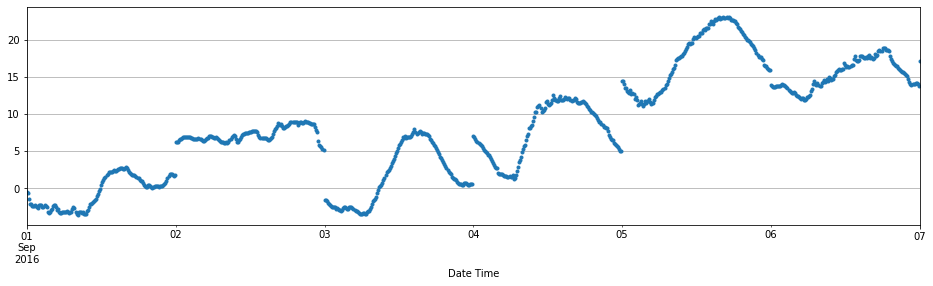

In [10]:
data.plot(figsize=(16,4),grid=True,style='.')

In [11]:
# преобразование pandas-таблицы в numpy-матрицу
X = data.values
X.shape

(865,)